In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.signal import find_peaks

import numpy.fft as fft

import os

In [2]:
ft = lambda x : np.abs(fft.fft(x))

In [3]:
def load_data(file_path):
    a = loadmat(file_path)
    a["data"] = a["data"] - np.mean(a["data"], axis=0) # Normalized height
    a["time"] = a["time"].reshape(-1)
    
    if max(abs(a["data"][:,0])) > max(abs(a["data"][:,1])):
        return a["data"][:,0], a["data"][:,1], a["time"]
    else:
        return a["data"][:,1], a["data"][:,0], a["time"]

    

In [4]:
def view_data(loaded_data, crop_l=-1, crop_h=100):
    wave1, wave2, time = loaded_data
    
    bol = (time > crop_l) & (time < crop_h)
    time = time[bol]
    wave1 = wave1[bol]
    wave2 = wave2[bol]
    
    fig, axs = plt.subplots(1,2, figsize=(8,3))

    axs[0].plot(time, wave1)
    axs[1].plot(time, wave2)
   
    return fig, axs

In [5]:
def view_transform(loaded_data, crop_l=-1, crop_h=100):
    wave1, wave2, time = loaded_data
    
    bol = (time > crop_l) & (time < crop_h)
    time = time[bol]
    wave1 = wave1[bol]
    wave2 = wave2[bol]
    
    nu = np.arange(len(time)) / (max(time) - min(time))
    fft1 = ft(wave1)
    fft2 = ft(wave2)
    
    fig, axs = plt.subplots(1,2, figsize=(8,3))

    axs[0].plot(nu, fft1)
    axs[1].plot(nu, fft2)


    axs[0].set_xlim([0,7])
    axs[1].set_xlim([0,7])
    
    return fig, axs

In [6]:
def find_freq(loaded_data, crop_l=-1, crop_h=100):
    wave1, wave2, time = loaded_data
    
    bol = (time > crop_l) & (time < crop_h)
    time = time[bol]
    wave1 = wave1[bol]
    wave2 = wave2[bol]
    
    nu = np.arange(len(time)) / (max(time) - min(time))
    fft1 = ft(wave1)
    fft2 = ft(wave2)
    fft_merge = np.sqrt((fft1/max(fft1))**2 + (fft2/max(fft2))**2)*np.sqrt(max(fft1)*max(fft2))
    
    fig, axs = plt.subplots(2,1, figsize=(8,6))

    axs[0].plot(time, wave1)
    axs[0].plot(time, wave2)
    

    axs[1].plot(nu, fft1)
    axs[1].plot(nu, fft2)
    axs[1].plot(nu, fft_merge)
    
    axs[1].set_xlim([0,7])
    
    peaks = find_peaks(fft_merge, prominence=10)[0]
    axs[1].scatter(nu[peaks], fft_merge[peaks], c='k')

    labels = np.round(nu[peaks],3)
    for peak in peaks:
        if nu[peak] < 7:
            axs[1].annotate(np.round(nu[peak],3), (nu[peak], fft_merge[peak]))
        
    return nu[peaks][nu[peaks] < 7]

# View all data

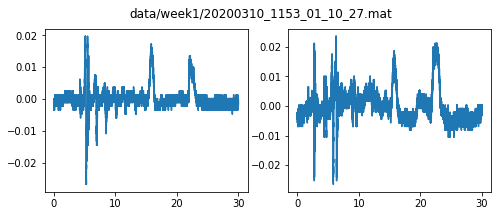

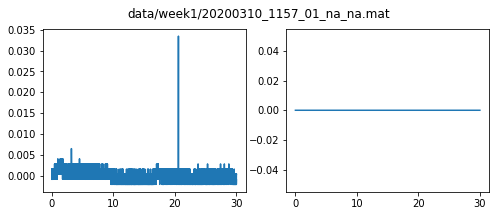

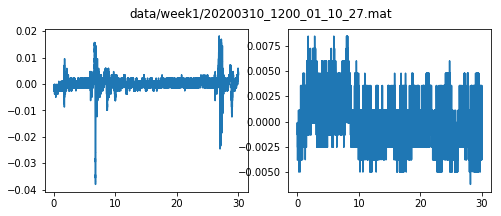

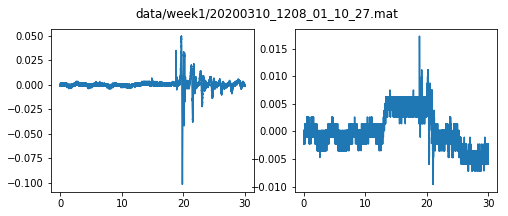

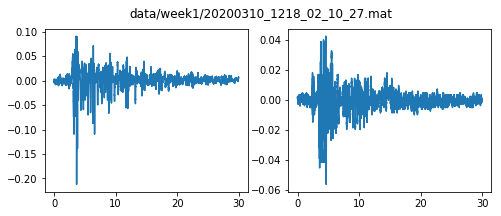

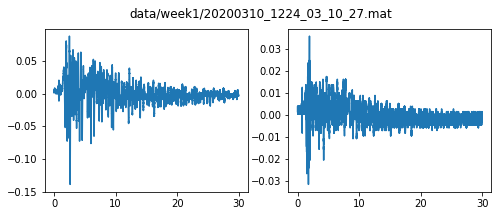

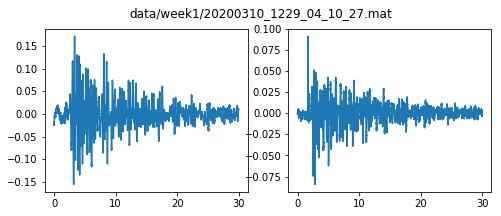

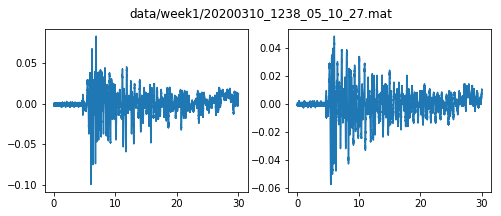

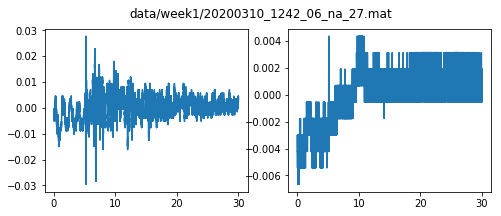

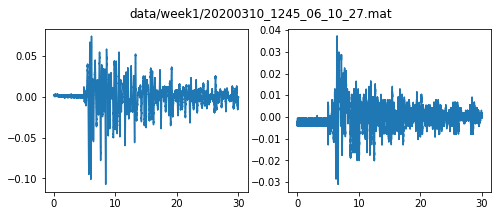

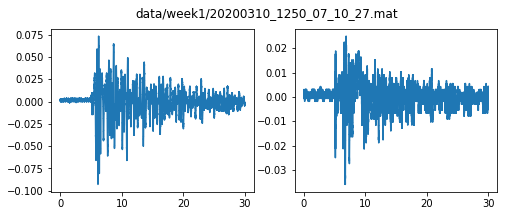

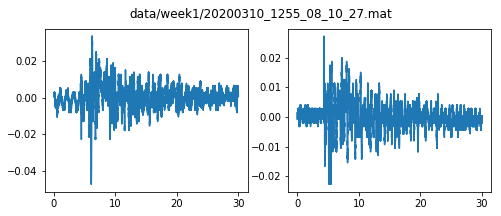

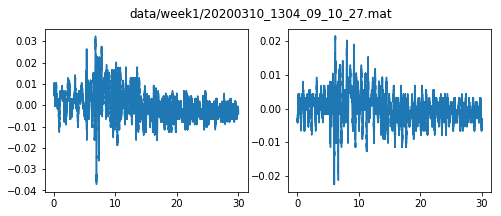

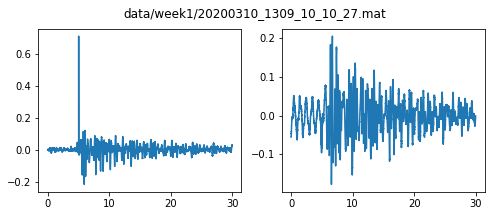

In [7]:
data_dir = "data/week1"

for file in sorted(os.listdir(data_dir)):
    file_path = os.path.join(data_dir, file)
    fig, axs = view_data(load_data(file_path))
    fig.suptitle(file_path)

# Only use good spectrums

In [8]:
datas = {
    2:load_data("data/week1/20200310_1218_02_10_27.mat"),
#     3:load_data("data/week1/20200310_1224_03_10_27.mat"),
    4:load_data("data/week1/20200310_1229_04_10_27.mat"),
    5:load_data("data/week1/20200310_1238_05_10_27.mat"),
    6:load_data("data/week1/20200310_1245_06_10_27.mat"),
    7:load_data("data/week1/20200310_1250_07_10_27.mat"),
    8:load_data("data/week1/20200310_1255_08_10_27.mat"),
#     9:load_data("data/week1/20200310_1304_09_10_27.mat"),
    10:load_data("data/week1/20200310_1309_10_10_27.mat")
}

# Cut off pre wave spectrum

In [9]:
# %matplotlib notebook

# data = 10
# crop = (6,30)
# view_data(datas[data], *crop)
# view_transform(datas[data], *crop)

In [10]:
crops = {
    2:(5,30),
    4:(4,30),
    5:(6,30),
    6:(6,30),
    7:(6,30),
    8:(7,30),
    10:(6,30)
}

# Do fourier transform to find peaks

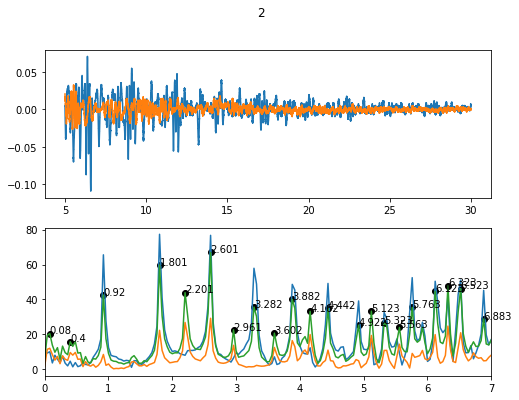

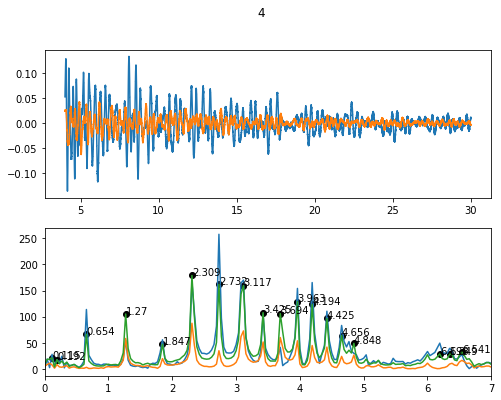

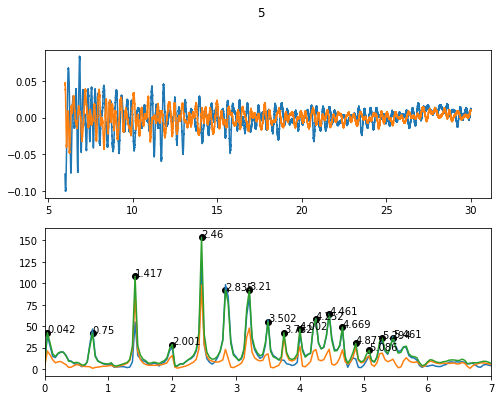

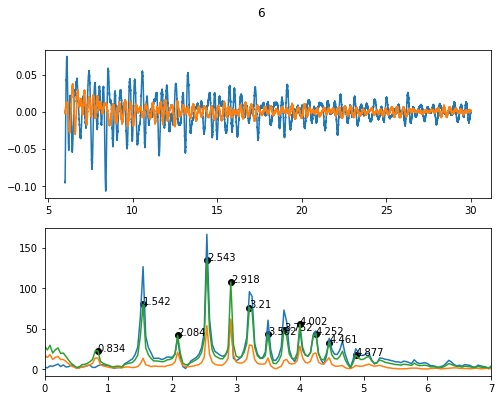

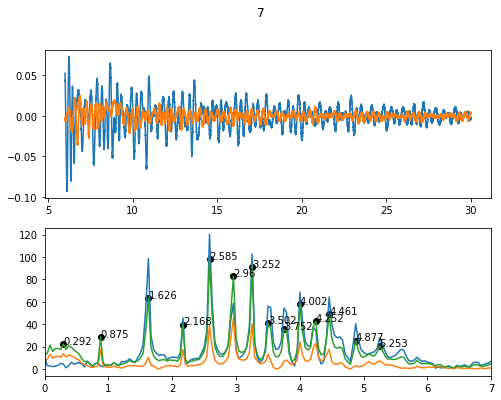

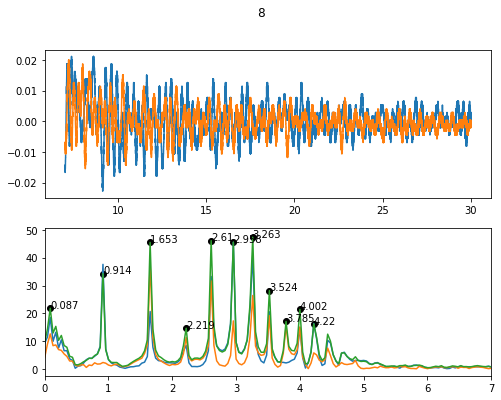

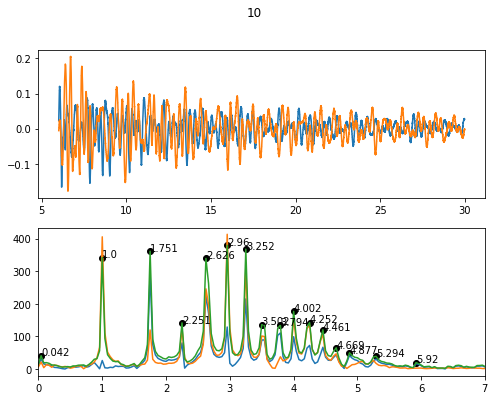

In [11]:
frequencies = {}
for depth in crops.keys():
    frequencies[depth] = find_freq(datas[depth], *crops[depth])
    plt.suptitle(depth)

# Match peaks to theory

In [12]:
freq_theory = lambda k, h : np.sqrt(9.81 * k*np.pi/0.495 * np.tanh(k*np.pi/0.495 * h/100))/(2*np.pi)

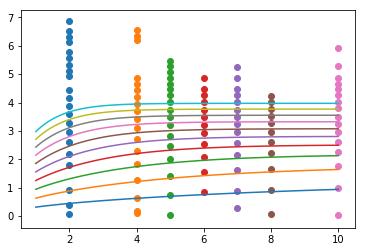

In [13]:
for depth, freq in frequencies.items():
    plt.scatter(np.ones_like(freq)*depth, freq)
    
hs = np.linspace(1, 10, 100)
for k in range(1, 11):
    plt.plot(hs, freq_theory(k, hs))

# Remove extra modes

In [14]:
frequencies_fixed = {2: [0.40019681, 0.92045266, 1.40171, 1.80088563, 2.20108244,
        2.60127925, 2.96145637, 3.28161382, 3.60177126, 3.88190903],
 4: [0.65414759, 1.2698159 , 1.84700495,
        2.30875618, 2.73202815, 3.11682085, 3.424655  , 3.69400989,
        3.96336478, 4.1942404],
 5: [0.75036558, 1.4173572 , 2.00097487, 2.45953162,
        2.83471441, 3.2098972 , 3.50170603, 3.75182789, 4.00194975,
        4.25207161],
 6: [0.83373953, 1.54241813, 2.08434883, 2.54290557, 2.91808836,
        3.2098972 , 3.50170603, 3.75182789, 4.00194975, 4.25207161],
 7: [0.87542651, 1.62579209, 2.16772278, 2.58459255,
        2.95977534, 3.25158417, 3.50170603, 3.75182789, 4.00194975,
        4.25207161],
 8: [0.91352035, 1.65303683, 2.21854943, 2.61005815,
        2.9580659 , 3.26257268, 3.5235785 , 3.78458431, 4.00208916,
        4.21959401],
 10: [1.00048744, 1.75085302, 2.25109673, 2.62627952,
        2.95977534, 3.25158417, 3.50170603, 3.79351487, 4.00194975,
        4.25207161]}

for key in frequencies_fixed.keys():
    frequencies_fixed[key] = np.array(frequencies_fixed[key])

# Fit gravity

In [15]:
freq_fit = lambda k, h : np.sqrt(11.01 * k*np.pi/0.493 * np.tanh(k*np.pi/0.493 * h/100))/(2*np.pi)

In [16]:
error = sum([(freq_fit(k,h) - frequencies_fixed[h][k-1])**2 
            for k in range(1, 11) 
            for h in frequencies_fixed.keys()])
error

0.027583177707337307

# Frequency as a function of mode and depth

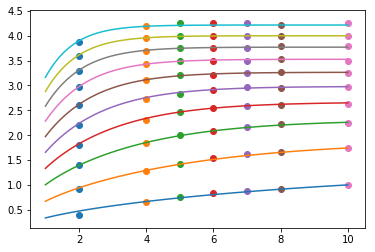

In [17]:
for depth, freq in frequencies_fixed.items():
    plt.scatter(np.ones_like(freq)*depth, freq)
    
hs = np.linspace(1, 10, 100)
for k in range(1, 11):
    plt.plot(hs, freq_fit(k, hs))

In [18]:
time_res = datas[2][2][1] - datas[2][2][0]
print(time_res)

frequency_error = frequencies_fixed[2]**2 * time_res
print(frequency_error)

0.0009151999999999999
[0.00014658 0.00077539 0.00179818 0.00296817 0.00443393 0.00619284
 0.00802651 0.00985578 0.01187267 0.01379135]


Text(0.5, 0, 'Water depth (cm)')

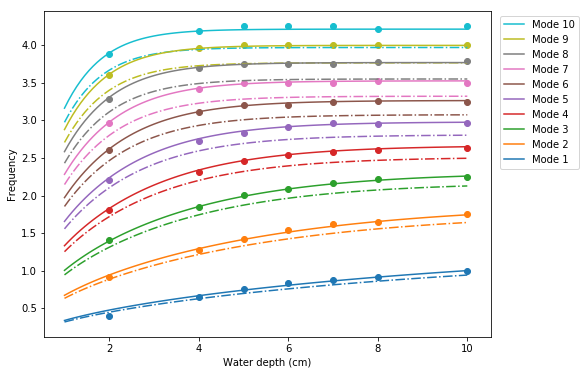

In [19]:
# for depth, freq in frequencies_fixed.items():
#     plt.scatter(np.ones_like(freq)*depth, freq)
    
depths = frequencies_fixed.keys()    

plt.figure(figsize=(8,6))

hs = np.linspace(1, 10, 100)
for k in range(10, 0, -1):
    color = "C{}".format(k-1)
    plt.plot(hs, freq_fit(k, hs), c=color, label="Mode {}".format(k))
    plt.plot(hs, freq_theory(k, hs), linestyle="-.", c=color)
    
    plt.scatter(depths, [frequencies_fixed[d][k-1] for d in depths], c=color)

plt.legend(bbox_to_anchor=(1.01, 1))
plt.ylabel("Frequency")
plt.xlabel("Water depth (cm)")

# Good Fourier transform

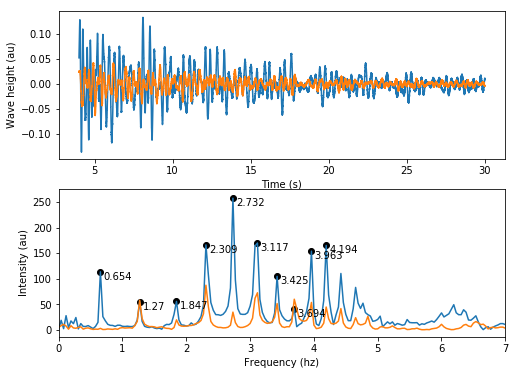

In [20]:
depth = 4
wave1, wave2, time = datas[depth]
crop_l, crop_h = crops[depth]
nu_peaks = frequencies_fixed[depth]


bol = (time > crop_l) & (time < crop_h)
time = time[bol]
wave1 = wave1[bol]
wave2 = wave2[bol]

nu = np.arange(len(time)) / (max(time) - min(time))
fft1 = ft(wave1)
fft2 = ft(wave2)

fft_peaks = fft1[[np.where(np.abs(nu - nu_peak) < 1e-2)[0][0] for nu_peak in nu_peaks]]


fig, axs = plt.subplots(2,1, figsize=(8,6))

axs[0].plot(time, wave1)
axs[0].plot(time, wave2)

axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Wave height (au)")

axs[1].plot(nu, fft1)
axs[1].plot(nu, fft2)

axs[1].set_xlim([0,7])
axs[1].set_xlabel("Frequency (hz)")
axs[1].set_ylabel("Intensity (au)")

axs[1].scatter(nu_peaks, fft_peaks, c='k')

for nu_peak, fft_peak in zip(nu_peaks, fft_peaks):
        axs[1].annotate(np.round(nu_peak,3), (nu_peak+0.05, fft_peak-15))

# Phase velocity

In [21]:
phase_v = {}
modes = np.arange(1,11)

for key in frequencies_fixed.keys():
    # w / k = (2pi f) / (n pi / L) = (2LF)/n
    phase_v[key] = 2* 0.495 * frequencies_fixed[key] / modes
    
phase_error = 2 * 0.495 * frequency_error / modes
print(phase_error)

[0.00014511 0.00038382 0.0005934  0.00073462 0.00087792 0.00102182
 0.00113518 0.00121965 0.00130599 0.00136534]


In [22]:
# w / k = sqrt(gk tanh(kh)) /k = sqrt(g tanh(kh)/ k)
phase_theory = lambda k, h : np.sqrt(9.81 * np.tanh(k*np.pi/0.493 * h/100) / ( k*np.pi/0.493) )
phase_fit = lambda k, h : np.sqrt(11.01 * np.tanh(k*np.pi/0.493 * h/100) / ( k*np.pi/0.493) )

Text(0.5, 0, 'Water depth (cm)')

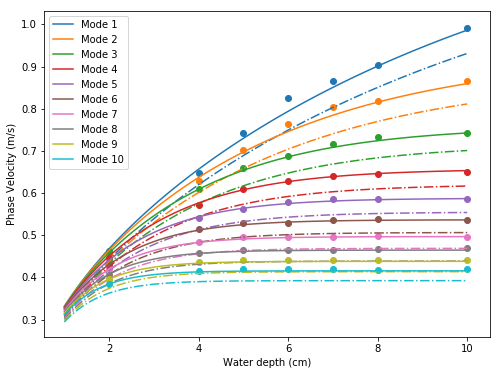

In [23]:
 depths = phase_v.keys()    

plt.figure(figsize=(8,6))

hs = np.linspace(1, 10, 100)
for k in range(1, 11):
    color = "C{}".format(k-1)
    plt.plot(hs, phase_fit(k, hs), c=color, label="Mode {}".format(k))
    plt.plot(hs, phase_theory(k, hs), linestyle="-.", c=color)
    
    plt.scatter(depths, [phase_v[d][k-1] for d in depths], c=color)

plt.legend()
plt.ylabel("Phase Velocity (m/s)")
plt.xlabel("Water depth (cm)")

# Group velocity

In [24]:
group_v = {}
modes = np.arange(1, 11)

norm_k = lambda k : k * np.pi / 0.493
norm_h = lambda h : h / 100

# w = sqrt(gk tanh(kh))
omega = lambda g, k, h : np.sqrt(g *norm_k(k) *np.tanh(norm_k(k) * norm_h(h)))

# v_g = 1/2w (gtanh(kh) + gkh sech(kh)^2) # Here we only include the numerator
group_v_top = lambda g, k, h: (g*np.tanh(norm_k(k) *norm_h(h)) 
                           + g*norm_k(k)*norm_h(h)/np.cosh(norm_k(k)*norm_h(h))**2)

for depth in frequencies_fixed.keys():
    # Use 11.01 because this is the experiemental gravity we found from the data
    # Here we have numerator divide denominator
    # Denominator = 2w = 2 * (2pi f)
    group_v[depth] = group_v_top(11.01, modes, depth) / (2*2*np.pi*frequencies_fixed[depth])
# phase_error = phase_error / 2 
# print(phase_error)

In [25]:
# Here we have numerator divide denominator
# Denominator = 2w
group_theory = lambda k, h : group_v_top(9.81, k, h) / (2 * omega(9.81, k, h))
group_fit = lambda k, h : group_v_top(11.01, k, h) / (2 * omega(11.01, k, h))

Text(0.5, 0, 'Water depth (cm)')

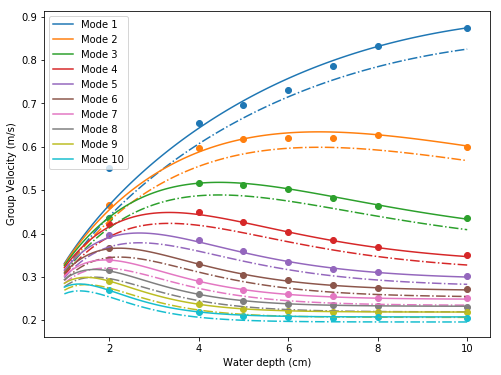

In [26]:
depths = phase_v.keys()    

plt.figure(figsize=(8,6))

hs = np.linspace(1, 10, 100)
for k in range(1, 11):
    color = "C{}".format(k-1)
    plt.plot(hs, group_fit(k, hs), c=color, label="Mode {}".format(k))
    plt.plot(hs, group_theory(k, hs), linestyle="-.", c=color)
    
    plt.scatter(depths, [group_v[d][k-1] for d in depths], c=color)

plt.legend()
plt.ylabel("Group Velocity (m/s)")
plt.xlabel("Water depth (cm)")